# **TSP MO** Problem

In [16]:
%pip install pymoo --quiet

Note: you may need to restart the kernel to use updated packages.


In [42]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)

## Definición del **Problema**
*problema implementado en el notebook "hito2-alumno" del moddle*

In [43]:
'''
# n_var: Número de variables (ciudades en este caso).
# n_obj: Número de objetivos (distancia total y tiempo total).
# n_constr: Número de restricciones (cero aquí).
# xl: Límite inferior para las variables de decisión (0).
# xu: Límite superior para las variables de decisión (1).
'''

class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities. Asegura que la matriz de distancias sea simétrica
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2 
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    ''' Calcula los objetivos (distancia total y tiempo total) para las soluciones propuestas en x. En x, cada fila es una solución codificada. '''
    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

## Diseño de la **Fase de Evaluación**

Inicialmente se diseña una fase de evaluación con **10 experimentos**, calculándose las métricas: [**Hipervolumen, Dispersión (SPR), Espaciado (SPA)**].

En la elección del mejor Frente de Pareto, se usa el hipervolumen.

In [44]:
from pymoo.indicators.hv import Hypervolume
import numpy as np


def calculate_metrics(front, ref_point):
    """ Calcula las métricas: hipervolumen, dispersión (SPR) y espaciado (SPA). """
    metricHV = Hypervolume(ref_point)
    
    hv = metricHV.do(front)

    # Dispersión: Diagonal de la hipercaja que contiene el frente
    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.linalg.norm(max_values - min_values)

    # Espaciado: Distancia promedio entre puntos del frente
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)  
    spa = np.mean(np.min(d + np.diag(np.inf * np.ones(len(d))), axis=1))  
    return hv, spr, spa

In [48]:
'''
    Ejecuta múltiples experimentos dado un problema y un algoritmo de optimización multi-objetivo. Se le pasa el punto de referencia del hipervolumen,
    el número de experimentos y el número de generaciones. El criterio de selección del mejor frente de pareto se puede modificar. Por defecto, se hace según 
    el hipervolumen. 

    @return
        - best_individual_ frnete_pareto [[distance1, time1], [distance2, time2], ...], 
        - metrics_summary: resumen de metricas de los 10 experimentos
        - ref_point: punto de referencia sobre el hipervolumen. Con este punto de referencia se calcula el hipervolumen del frente de pareto del algoritmo NSGA2 a superar

'''
def multiple_experiments_with_metrics(problem, algorithm, n_gens, ref_point, num_experiments=10, termination=get_termination("n_eval", 100000)):
    best_individual = None
    best_hypervolume = -float('inf')  # el signo negativo para maximizar el hipervolumen
    metrics_summary = []

    for i in range(num_experiments):   
        # NUESTRO ALGORITMO
        res = minimize(problem, algorithm, ('n_gen', n_gens), verbose=False)

        front = res.F # frente de pareto
        if front is None:
            continue

        if i == 0:
            # El ref_point, tras el primer experimento, es el mismo incrementado por 1.3
            ref_point = np.max(front, axis=0) * 1.3  # un pequeño incremento sobre el máximo para el punto de referencia

        hv, spr, spa = calculate_metrics(front, ref_point)
        metrics_summary.append((hv, spr, spa))

        print(f"Ejecución {i+1}:  Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # selecciona el mejor frente según un criterio (en este caso, hipervolumen: SE PUEDE CAMBIAR)
        if hv > best_hypervolume:
            best_hypervolume = hv
            best_individual = res.F

    # Promedios y desviaciones estándar de las métricas
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return best_individual, metrics_summary, ref_point

## Algoritmo 1-prueba
*NSGA2 con 10 generaciones comparado con el objetivo*

Ejecución 1:  Hipervolumen: 8514225.9322, Dispersión (SPR): 1095.9471, Espaciado (SPA): 166.6351
Ejecución 2:  Hipervolumen: 9343893.3913, Dispersión (SPR): 1931.6147, Espaciado (SPA): 247.8108
Ejecución 3:  Hipervolumen: 9756044.6471, Dispersión (SPR): 2051.9999, Espaciado (SPA): 383.2141
Ejecución 4:  Hipervolumen: 8463808.0315, Dispersión (SPR): 3603.5500, Espaciado (SPA): 327.6731
Ejecución 5:  Hipervolumen: 9404503.1021, Dispersión (SPR): 3465.2864, Espaciado (SPA): 414.8075
Ejecución 6:  Hipervolumen: 8039777.4406, Dispersión (SPR): 2258.6333, Espaciado (SPA): 221.1381
Ejecución 7:  Hipervolumen: 8038112.8294, Dispersión (SPR): 4335.1995, Espaciado (SPA): 296.2083
Ejecución 8:  Hipervolumen: 7969441.8765, Dispersión (SPR): 4363.4372, Espaciado (SPA): 569.6303
Ejecución 9:  Hipervolumen: 8418154.5083, Dispersión (SPR): 3865.4372, Espaciado (SPA): 241.1742
Ejecución 10:  Hipervolumen: 8676979.0233, Dispersión (SPR): 2178.7976, Espaciado (SPA): 346.6593

--- Resumen de Métricas ---


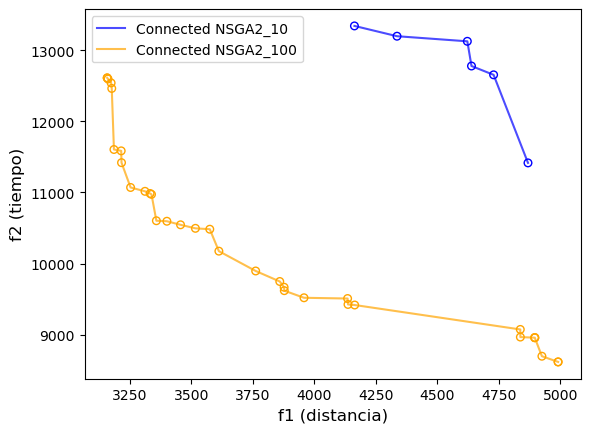

In [50]:
problem = TSPProblem(100)
algorithm = NSGA2(pop_size=100)
ref_point = [20000, 50000]

# NUESTRO ALGORITMO
best_solution, metrics_summary, ref_point = multiple_experiments_with_metrics(problem, algorithm, n_gens=10, ref_point=ref_point, num_experiments=10)
# ALGORITMO NSGA2 A BATIR
res_obj = minimize(problem, algorithm, ('n_gen', 100), verbose=False) # Algoritmo de optimización a batir

hv, spr, spa = calculate_metrics(best_solution, ref_point)
hv_obj, spr_obj, spa_obj = calculate_metrics(res_obj.F, ref_point)

data = {'Hipervolumen': [hv, hv_obj], 'Dispersión (SPR)': [spr, spr_obj], 'Espaciado (SPA)': [spa, spa_obj]}

df = pd.DataFrame(data, index=['Mejor Solución', 'NSGA2 a Batir'])
print(f"\n {df}")

#########################################################
######################## Gráfica ########################
#########################################################

sorted_res = best_solution[np.argsort(best_solution[:, 0])]
sorted_res2 = res_obj.F[np.argsort(res_obj.F[:, 0])]

# líneas que conectan los puntos de NSGA2_10 y NSGA2_100
plt.plot(sorted_res[:, 0], sorted_res[:, 1], color="blue", alpha=0.7, label="Connected NSGA2_10")
plt.plot(sorted_res2[:, 0], sorted_res2[:, 1], color="orange", alpha=0.7, label="Connected NSGA2_100")

plt.scatter(best_solution[:, 0], best_solution[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(res_obj.F[:, 0], res_obj.F[:, 1], s=30, facecolors='none', edgecolors='orange')

# Rellena los puntos scatter con color
# plt.scatter(best_solution[:, 0], best_solution[:, 1], s=30, c='blue', edgecolors='blue')
# plt.scatter(res_obj.F[:, 0], res_obj.F[:, 1], s=30, c='orange', edgecolors='orange')

plt.xlabel('f1 (distancia)', fontsize=12)
plt.ylabel('f2 (tiempo)', fontsize=12)
plt.legend()

plt.show()